In [1]:

import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [120]:


def load_data(path):
    columns = [
        'event',
        'time',
        'value',
    ]
    df = pandas.read_csv(path, names=columns)
    df = df[df.event.isin(['val'])]
    df = df.drop(columns=['event'])
    df['time'] = pandas.to_timedelta(df['time'], unit='ms')
    df = df.set_index('time')
    return df

#data = load_data('../data/first-100hz-pulse-sitting-thumb-1.csv')
data = load_data('../green4-25hz-pointy-30s-2.csv')
data

,value
time,
0 days 01:59:11.120000,41
0 days 01:59:11.160000,42
0 days 01:59:11.200000,44
0 days 01:59:11.240000,44
0 days 01:59:11.280000,46
...,...
0 days 01:59:43.960000,36
0 days 01:59:44,37
0 days 01:59:44.040000,40


<Axes: xlabel='time', ylabel='value'>

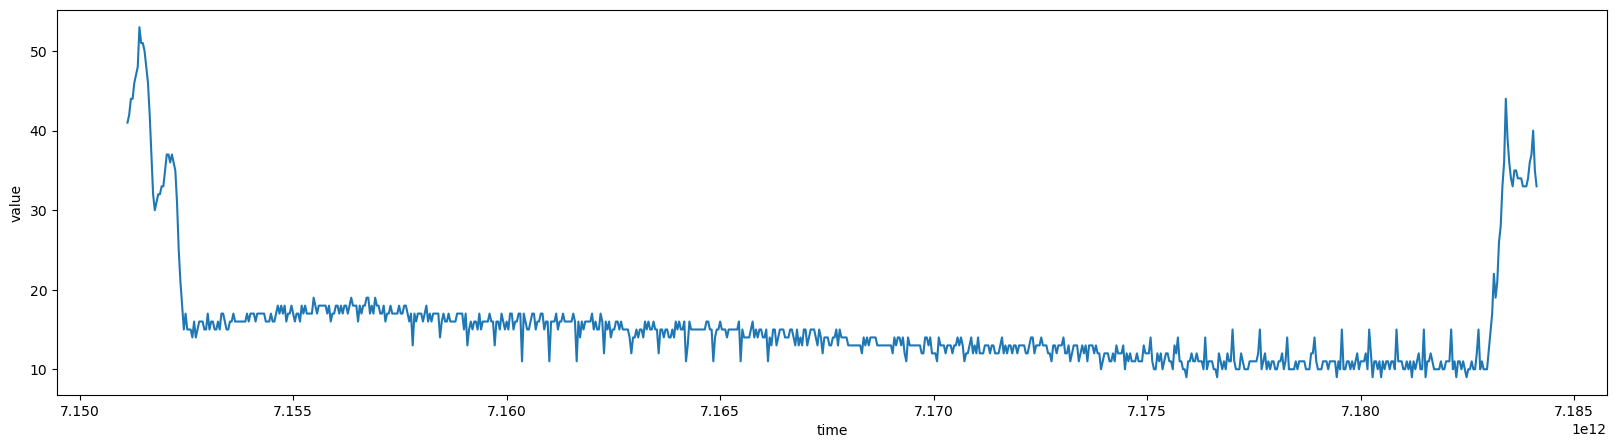

In [121]:
fig, ax = plt.subplots(1, figsize=(20, 5))
seaborn.lineplot(ax=ax, data=data.reset_index(), x='time', y='value')

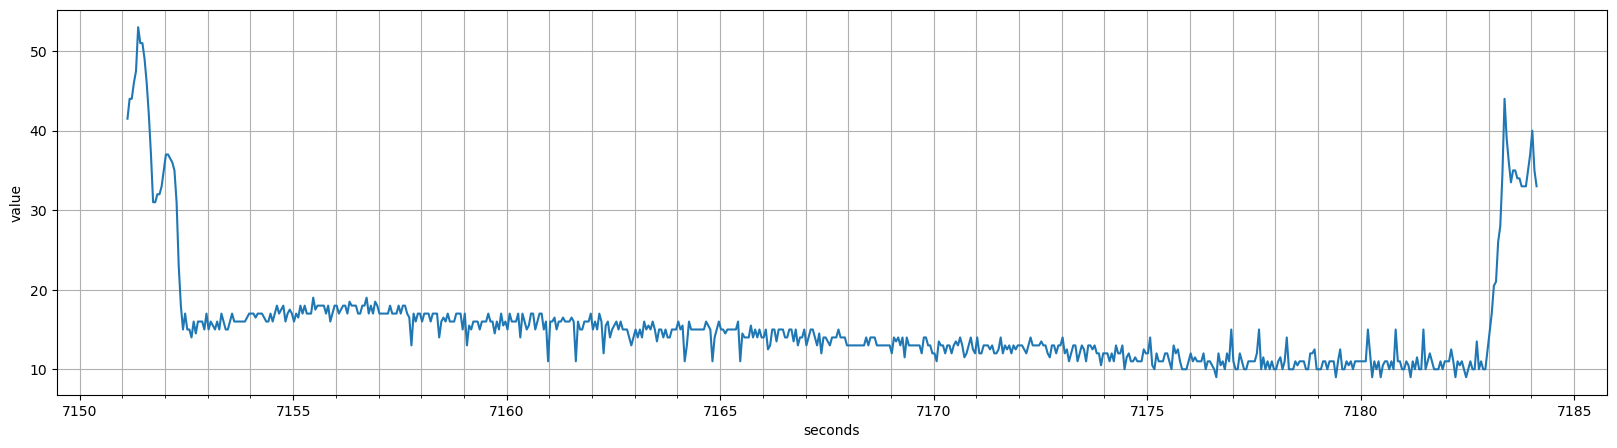

In [122]:

    rr = data.resample('50ms').median()
fig, ax = plt.subplots(1, figsize=(20, 5))
rr = rr.reset_index()
rr['seconds'] = rr['time'].dt.total_seconds()
seaborn.lineplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')
#seaborn.scatterplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')

from matplotlib import ticker
#ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(which='minor')
ax.grid(which='major')


,time,value,seconds
0,0 days 01:59:11.120000,NaN,7151.12
1,0 days 01:59:11.160000,NaN,7151.16
2,0 days 01:59:11.200000,NaN,7151.20
3,0 days 01:59:11.240000,NaN,7151.24
4,0 days 01:59:11.280000,NaN,7151.28
...,...,...,...
819,0 days 01:59:43.960000,33.0,7183.96
820,0 days 01:59:44,34.0,7184.00
821,0 days 01:59:44.040000,34.0,7184.04
822,0 days 01:59:44.080000,34.0,7184.08


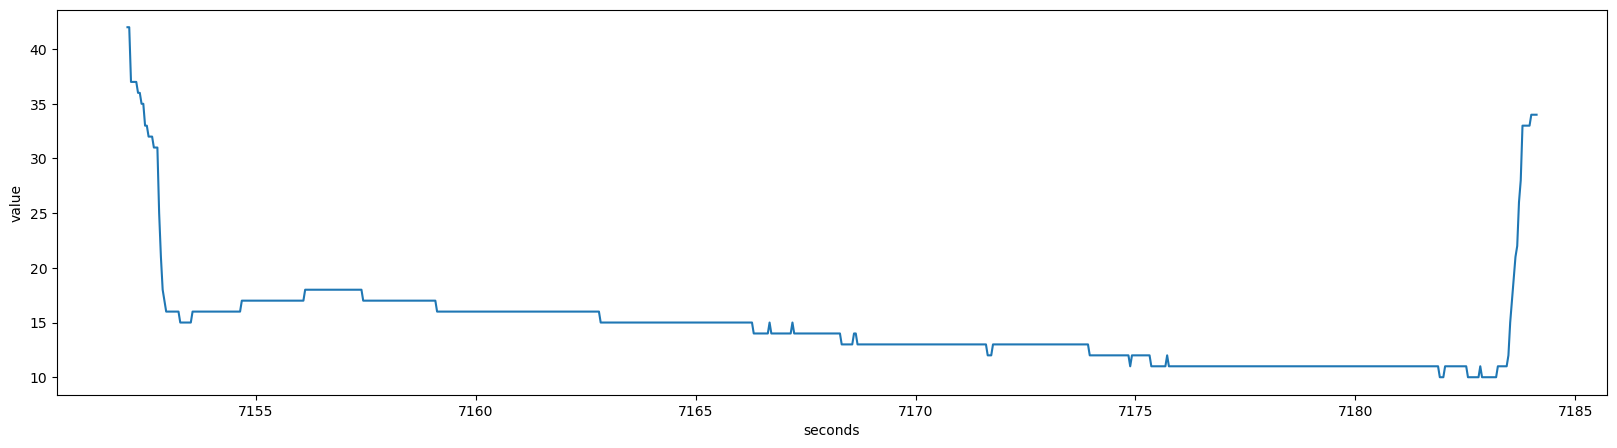

In [123]:
ss = data.rolling(window=25).median()
fig, ax = plt.subplots(1, figsize=(20, 5))
ss = ss.reset_index()
ss['seconds'] = ss['time'].dt.total_seconds()
seaborn.lineplot(ax=ax, data=ss.reset_index(), x='seconds', y='value')
ss

,value
time,
0 days 01:59:11.120000,NaN
0 days 01:59:11.160000,NaN
0 days 01:59:11.200000,NaN
0 days 01:59:11.240000,NaN
0 days 01:59:11.280000,NaN
...,...
0 days 01:59:43.960000,33.0
0 days 01:59:44,34.0
0 days 01:59:44.040000,34.0


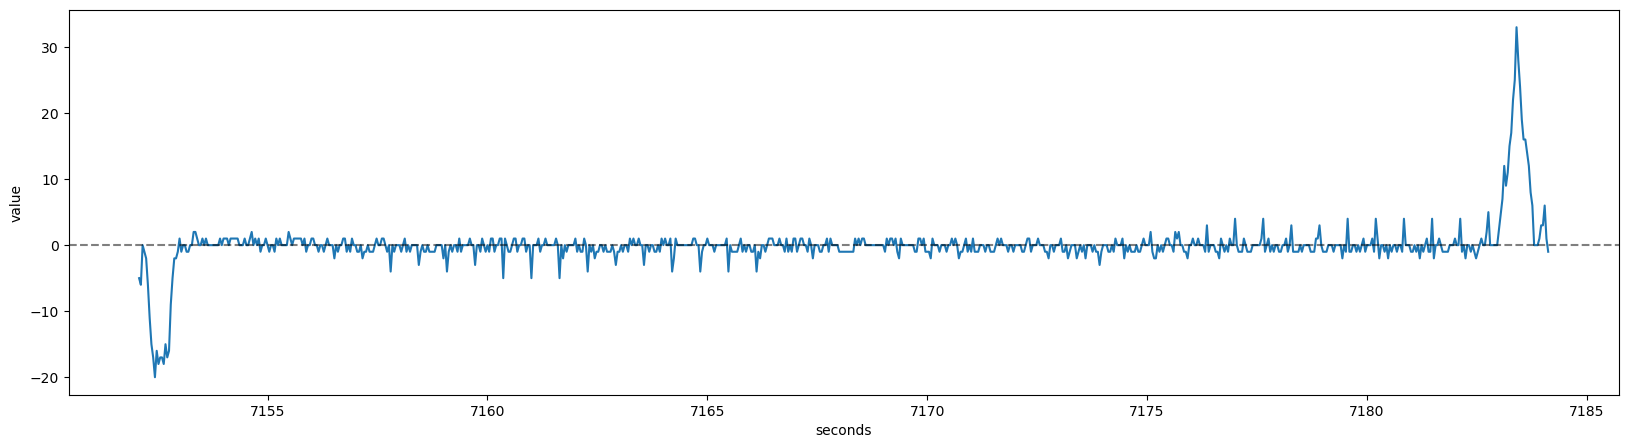

In [124]:
ss = data.rolling(window=25).median()
fig, ax = plt.subplots(1, figsize=(20, 5))
rr = data.copy()
rr['value'] = rr['value'] - ss['value']
rr['seconds'] = rr.index.total_seconds()
seaborn.lineplot(ax=ax, data=rr.reset_index(), x='seconds', y='value')
ax.axhline(0.0, ls='--', color='black', alpha=0.5)
ss

In [125]:
sub =  rr[(rr.seconds > 7154) & (rr.seconds < 7182)]
sub

,value,seconds
time,,
0 days 01:59:14.040000,1.0,7154.04
0 days 01:59:14.080000,1.0,7154.08
0 days 01:59:14.120000,0.0,7154.12
0 days 01:59:14.160000,1.0,7154.16
0 days 01:59:14.200000,1.0,7154.20
...,...,...
0 days 01:59:41.800000,-1.0,7181.80
0 days 01:59:41.840000,-1.0,7181.84
0 days 01:59:41.880000,0.0,7181.88


<Axes: xlabel='bpm', ylabel='value'>

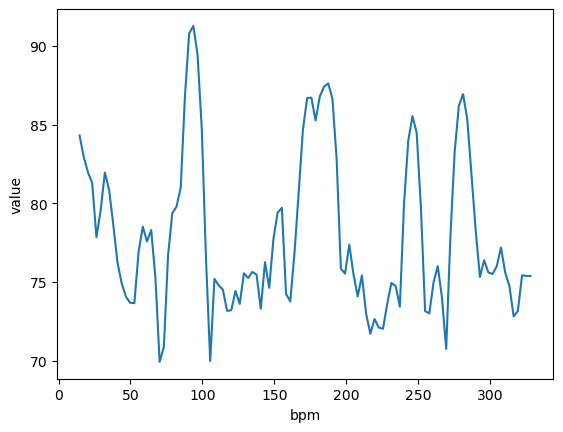

In [126]:
import scipy.signal

def spectrum_stft(audio, sr, n_fft, window):
    """Method 1: Compute magnitude spectrogram, average over time"""
    S = librosa.stft(audio, n_fft=n_fft, window=window)
    S_db = librosa.amplitude_to_db(numpy.abs(S*S), ref=0.0, top_db=120)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    spectrum = numpy.mean(S_db, axis=1)
    return pandas.Series(spectrum, index=freqs)

def spectrum_welch(audio, sr, n_fft, window):
    """Method 2: Use Welch method. Uses overlapped complex spectrum"""
    freqs, power = scipy.signal.welch(audio, fs=sr, nfft=n_fft, window=window,
        scaling="spectrum", average='median')
    db = librosa.power_to_db(power, ref=0.0, top_db=120)
    return pandas.Series(db, index=freqs)

spectrum = spectrum_welch(sub.value, sr=25, n_fft=512, window='hann')
spectrum = spectrum.to_frame()
spectrum.index.name='frequency'
spectrum = spectrum.rename(columns={0: 'value'})
spectrum = spectrum.loc[0.20:5.5]
spectrum['bpm'] = spectrum.index * 60
seaborn.lineplot(data=spectrum.reset_index(), x='bpm', y='value')

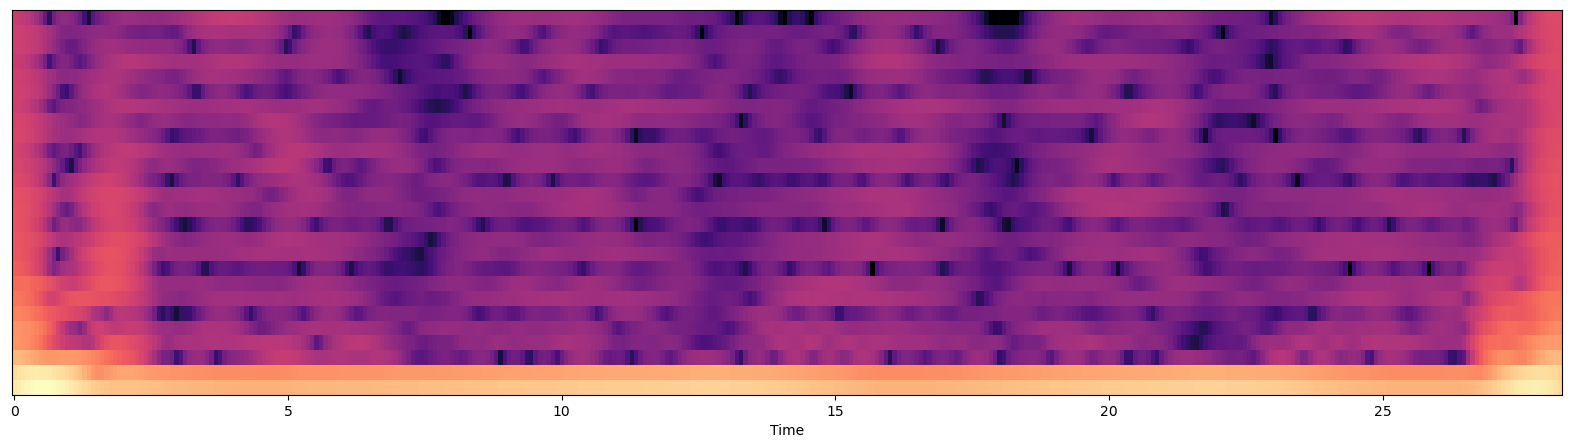

In [82]:
import librosa

hop = 2
n_fft = 50

fig, ax = plt.subplots(1, figsize=(20, 5))
S = numpy.abs(librosa.stft(y=data.value.astype(float).values, hop_length=hop, n_fft=n_fft))
S_db = librosa.amplitude_to_db(S, ref=0.0)

librosa.display.specshow(S_db, ax=ax, sr=25, x_axis='time', hop_length=hop)
